<b><h1>Disco Data Processing Script</h1>
<h2>Part 1 Reading and Cleaning Data</h2></b>

Prior to running the script, please ensure you have inserted all raw books to be analyzed inside the input directory.
    
<b>For example:</b>    
disco-data-processing.py

input/all raw books in here
     

In [145]:
# importing required libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib import pyplot

In [2]:
import os 
import glob

#PART 1 -------- Reading in Data and Visualizing the Results

#assign local path to raw Excel books
raw_book_path = os.path.abspath('input')
print('Searching in directory:', raw_book_path, '\n')

#list all raw books in file
list_of_raw_books = glob.glob("input/*.xlsx")
print('Raw books to be analyzed are: ', list_of_raw_books, '\n')

Searching in directory: /Users/s.stuart/Documents/Python/disco-data-processing/input 

Raw books to be analyzed are:  ['input/sample_raw.xlsx'] 



In [3]:
#initialize a global list to hold all dataframes generated of Excel books analyzed in this script
clean_book_df_list = []

#Each loop iteration reviews the data of one raw book (i.e. one polymer) from the input folder
for b in list_of_raw_books:
    
    print("The current book being analyzed is: ", b)

    #determine the number of sheets, samples, & controls in the workbook
    name_sheets = pd.ExcelFile(b).sheet_names
    num_sheets = (len(pd.ExcelFile(b).sheet_names))
    
    #initialize number of samples and controls to zero, then initialize the "list initializers" which will become global lists .
    num_samples = 0
    num_controls = 0
    sample_control_initializer = []
    sample_replicate_initializer = []
    control_replicate_initializer = []
    
    #initialize a list to contain the experimental dataframes collected for this book, which will be concatenated at the end to create one dataframe "big_df" that represents this book
    df_list = []

    #loop through sheet names to determine number of samples and controls in this book
    for s in range(len(name_sheets)):
        #if the current sheet is labeled Sample: 
        #increment sample counter, add a list item called 'sample' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.
        if ('Sample' or 'sample') in name_sheets[s]:
            num_samples += 1
            sample_control_initializer.append('sample')
            sample_replicate_initializer.append(num_samples)
            
        #if the current sheet is labeled Control: 
        #increment control counter, add a list item called 'control' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.   
        elif ('Control' or 'control') in name_sheets[s]:
            num_controls += 1
            sample_control_initializer.append('control')
            control_replicate_initializer.append(num_controls)
    
    print("There are", num_sheets, "sheets identified in the current book.")
    print("Number of samples sheets identified:", num_samples)
    print("Number of control sheets identified:", num_controls)
    
    if num_samples != num_controls:
        print('\nERROR: The number of sample sheets is not equal to the number of control sheets in', b, 'please confirm the data in the book is correct.')
    
    #combine sample and control initializers to create the total replicate index list
    total_replicate_index = sample_replicate_initializer + control_replicate_initializer
    
    print("Book-level data aquisition complete. Beginning replicate-specific data acquisition.")


    #FOR TEST PURPOSES SET NUM SHEETS TO 1
#     num_sheets=1

    #loop through each sheet in the workbook
    for n in range(num_sheets):

        #read in the current book's nth sheet into a Pandas dataframe
        current_sheet_raw = pd.read_excel(b, sheet_name=n)
        print("Reading Book Sheet:", n)

        #drop first always empty unnamed col
        to_drop = ['Unnamed: 0']
        current_sheet_raw.drop(columns = to_drop, inplace = True)

        #loop through columns and "fill right" to replace all Unnamed columns with the right title_string value
        for c in current_sheet_raw.columns:
            current_sheet_raw.columns = [current_sheet_raw.columns[i-1] if 'Unnamed' in current_sheet_raw.columns[i] else current_sheet_raw.columns[i] for i in range(len(current_sheet_raw.columns))]

        #identifies the coordinates of the left-most parameter in each experimental set, conc (um)
        i, c = np.where(current_sheet_raw == 'conc (um)')

        #assigns coordinates of all 'conc (um) cells to an index (row) array and a column array
        conc_indices = current_sheet_raw.index.values[i]
        conc_columns = current_sheet_raw.columns.values[c]

        #determine the number of experimental rows in each NMR results set, applies to whole book
        #subtract one to exclude conc itself
        num_experimental_indices = np.unique(conc_indices)[2] - np.unique(conc_indices)[1] - 1
        # print("The number of experimental indices are:", num_experimental_indices)

        #determine the number of experimental columns in each NMR results set, applies to whole book
        (unique_exp_cols, count_experimental_cols) = np.unique(conc_columns, return_counts = True)
        num_experimental_cols = np.unique(count_experimental_cols)[0]
        # print("The number of experimental columns are:", num_experimental_cols)

        #initialize/reset dfs
        current_exp_df = []
        big_df = []

        #within the current_sheet_raw, [i,j] will be the row and column indices of the concentration cell for each experimental set
        for i in conc_indices:
            for j in conc_columns:

                #Determine the current sample_or_control and replicate by taking the nth value (aka current sheet value) from the lists determined above
                current_sample_or_control = sample_control_initializer[n]
                current_replicate = total_replicate_index[n]

                #assigns current values to the fixed experimental parameters for this set
                fixed_parameters_per_set = current_sheet_raw.loc[i,j]

                current_title_string = fixed_parameters_per_set.index[0]
                current_concentration = fixed_parameters_per_set[1]
                current_sat_time = fixed_parameters_per_set[3]
                current_irrad_bool = fixed_parameters_per_set[5]

                #initialize/reset experimental lists to null for this experimental set
                list_current_ppm_experimental = []
                list_current_intensity_experimental = []
                list_current_width_experimental = []
                list_current_area_experimental = []
                list_current_type_experimental = []
                list_current_flags_experimental = []
                list_current_impuritycomp_experimental = []
                list_current_annotation_experimental = []
                list_current_range_experimental = []
                list_current_normalized_experimental = []
                list_current_absolute_experimental = []

                #  now need to find and assign experimental values to new lists, in a generalizable way
                experimental_index_starter = i+1
        #         print("Experimental Index Starter is:", experimental_index_starter)

                experimental_index_range = range(num_experimental_indices)
        #         print("Experimental Index Range is:", experimental_index_range)

                experimental_column_range = range(num_experimental_cols)
        #         print("Experimental Column Range is:", experimental_index_range)

                combined_experimental_index_range = experimental_index_starter + experimental_index_range
        #         print("Combined Experimental Index Range is:", combined_experimental_index_range)

                #Obtain experimental column range using boolean mask as column labels are title_strings for each experimental set
                experimental_column_range_mask = current_sheet_raw.columns.get_loc(j)
                combined_experimental_column_range = np.where(experimental_column_range_mask)
        #         print("Combined Experimental Column Range is:", combined_experimental_column_range)

                #loop through and collect experimental index and experimental column range for the ith and jth experimental set
                for ei in combined_experimental_index_range:
                    for ec in combined_experimental_column_range:

        #               use iloc to grab NMR experimental variables for this set into a series
                        variable_parameters_per_set = current_sheet_raw.iloc[ei,ec]
        #                 print(variable_parameters_per_set)

        #               append designated variable parameters from the generated Series' into lists for those parameters for this experimental set 
                        list_current_ppm_experimental.append(variable_parameters_per_set.iloc[1])
                        list_current_intensity_experimental.append(variable_parameters_per_set.iloc[2])
                        list_current_width_experimental.append(variable_parameters_per_set.iloc[3])
                        list_current_area_experimental.append(variable_parameters_per_set.iloc[4])
                        list_current_type_experimental.append(variable_parameters_per_set.iloc[5])
                        list_current_flags_experimental.append(variable_parameters_per_set.iloc[6])
                        list_current_impuritycomp_experimental.append(variable_parameters_per_set.iloc[7])
                        list_current_annotation_experimental.append(variable_parameters_per_set.iloc[8])
                        list_current_range_experimental.append(variable_parameters_per_set.iloc[11])
                        list_current_normalized_experimental.append(variable_parameters_per_set.iloc[12])
                        list_current_absolute_experimental.append(variable_parameters_per_set.iloc[13])

                #after all the experimental lists are populated, define length of the experimental parameter lists (number of true experimental rows)
                exp_list_length = len(list_current_ppm_experimental)
        #                 print('Experimental List Length is:', exp_list_length)

                #create "range" lists of the fixed experimental values to be the same length as variable experimental values, so we can add both to the same dataframe
                ranged_sample_or_control = exp_list_length * [current_sample_or_control]
                ranged_replicate = exp_list_length * [current_replicate]
                ranged_title_string = exp_list_length * [current_title_string]
                ranged_concentration = exp_list_length * [current_concentration] 
                ranged_sat_time = exp_list_length * [current_sat_time]
                ranged_irrad_bool = exp_list_length * [current_irrad_bool]


                #assign all current experimental values for this experimental set to a dataframe
                current_exp_df = pd.DataFrame(list(zip(ranged_sample_or_control, ranged_replicate, ranged_title_string, 
                                                              ranged_concentration, ranged_sat_time, ranged_irrad_bool,
                                                              list_current_ppm_experimental, list_current_intensity_experimental,
                                                              list_current_width_experimental, list_current_area_experimental,
                                                              list_current_type_experimental, list_current_flags_experimental, 
                                                              list_current_impuritycomp_experimental, list_current_annotation_experimental,
                                                              list_current_range_experimental, list_current_normalized_experimental, 
                                                              list_current_absolute_experimental)),

                                                     columns = ['sample_or_control', 
                                                                'replicate', 
                                                                'title_string', 
                                                                'concentration', 
                                                                'sat_time', 
                                                                'irrad_bool', 
                                                                'ppm', 'intensity',
                                                                'width', 'area', 'type',
                                                                'flags', 'impurity_compound',
                                                                'annotation', 'range', 'normalized', 'absolute'])


                #before moving on to next experimental set, append the dataframe from this experimental set to a book-level list of dataframes
                df_list.append(current_exp_df)

            print("Data frame for the experimental set at coordinates:", i, j, "has been appended to the global list of dataframes.")

    #after looping through all sheets in the book, and after appending all experimental dataframes from each sheet to a list...
    #concatenate the global list of dataframes into one big beautiful clean dataframe!
    big_df = pd.concat(df_list)
#     big_df.to_excel("big_df.xlsx")
    print("The current book has been concatenated into a dataframe!")

    #Before looping to the next book, append big_df containing the current book to the global list "clean_book_df_list"
    clean_book_df_list.append(big_df)

#after looping through all books in the input folder, concatenate all book level dataframes into one collective dataframe, title strings will be unique
collective_books_df = pd.concat(clean_book_df_list)
print("Done - global list of books has been concatenated into one big beautiful dataframe!")
# print("The collective dataframe for all books is")
# collective_books_df

The current book being analyzed is:  input/sample_raw.xlsx
There are 6 sheets identified in the current book.
Number of samples sheets identified: 3
Number of control sheets identified: 3
Book-level data aquisition complete. Beginning replicate-specific data acquisition.
Reading Book Sheet: 0
Data frame for the experimental set at coordinates: 1 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 1 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 1 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 1 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 1 from 2020013

Data frame for the experimental set at coordinates: 91 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 100 from 20200130-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental s

Data frame for the experimental set at coordinates: 55 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 64 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 64 from 20200130-2-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the exp

Data frame for the experimental set at coordinates: 19 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 19 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 19 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 28 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 28 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 28 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the exp

Data frame for the experimental set at coordinates: 109 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 109 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 118 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 118 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 118 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 118 from 20200130-3-500KHABSM-3p450mgml (Second Difference) has been appended to the global list of dataframes.
Data frame for t

Data frame for the experimental set at coordinates: 91 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 91 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 100 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 100 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 100 from 20200130-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental

Data frame for the experimental set at coordinates: 73 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 73 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 73 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 73 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 73 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 82 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 82 from 20200130-2-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the e

Data frame for the experimental set at coordinates: 46 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 55 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the experimental set at coordinates: 64 from 20200130-3-500KHA-3p450mgml has been appended to the global list of dataframes.
Data frame for the e

,sample_or_control,replicate,title_string,concentration,sat_time,irrad_bool,ppm,intensity,width,area,type,flags,impurity_compound,annotation,range,normalized,absolute
0,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,ppm,Intensity,Width,Area,Type,Flags,Impurity/Compound,Annotation,Range,Normalized,Absolute
1,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,4.21,2.11,26.94,1020.35,Compound,None,NaN,NaN,4.3199 .. 4.1667,2.96,1021.35
2,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,4.13,1.9123,23.86,819.22,Compound,None,NaN,NaN,4.1667 .. 4.0025,2.65,914.048
3,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,3.51,9.5708,9525.91,1.63681e+06,Compound,None,NaN,NaN,3.5985 .. 3.4369,11.55,3984.77
4,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,3.19,11.4251,27.85,5711.8,Compound,None,NaN,NaN,3.2205 .. 3.1641,9.71,3350.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.51,8.5976,26.64,4112.37,Compound,None,NaN,NaN,3.5985 .. 3.4369,11.36,3494.63
4,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.19,10.4554,26.39,4953.12,Compound,None,NaN,NaN,3.2205 .. 3.1641,9.77,3005.02
5,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.01,4.6352,32.52,2706.3,Compound,None,NaN,NaN,3.0701 .. 2.9498,7.08,2178.16
6,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,1.69,54.9369,4.15,4097.72,Compound,None,NaN,NaN,1.7148 .. 1.6698,12.96,3989.01


In [12]:
#remove rows that contain only redundant experimental parameter titles, contained in each index 0 row:
#assign prosepctive redundant title rows at index zero to a variable
collective_books_df_redundant = collective_books_df[collective_books_df.index == 0]

#to make sure prospective redundant rows are actually redundant, check if there is only one unique intensity value in these suspect rows (i.e. suspect rows only contain the title value for intensity, indicating they are redundant)
if collective_books_df_redundant.nunique().loc['intensity'] == 1:
    collective_books_df_clean = collective_books_df[collective_books_df.index != 0]

#remove duplicate rows
collective_books_df_clean = collective_books_df_clean.drop_duplicates()

#export collective book to excel output
output_directory = "output"
output_file_name = "output.xlsx"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
print('Exporting cleaned global dataframe for all provided books to output directory... this may take a moment.')
collective_books_df_clean.to_excel(os.path.join(output_directory, output_file_name))

print('Export complete! Navigate to output directory to see the clean Excel file.')

collective_books_df_clean

Exporting cleaned global dataframe for all provided books to output directory... this may take a moment.
Export complete! Navigate to output directory to see the clean Excel file.


,sample_or_control,replicate,title_string,concentration,sat_time,irrad_bool,ppm,intensity,width,area,type,flags,impurity_compound,annotation,range,normalized,absolute
1,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,4.21,2.11,26.94,1020.35,Compound,None,NaN,NaN,4.3199 .. 4.1667,2.96,1021.35
2,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,4.13,1.9123,23.86,819.22,Compound,None,NaN,NaN,4.1667 .. 4.0025,2.65,914.048
3,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,3.51,9.5708,9525.91,1.63681e+06,Compound,None,NaN,NaN,3.5985 .. 3.4369,11.55,3984.77
4,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,3.19,11.4251,27.85,5711.8,Compound,None,NaN,NaN,3.2205 .. 3.1641,9.71,3350.94
5,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,1.0,3.01,5.0383,34.09,3083.2,Compound,None,NaN,NaN,3.0701 .. 2.9498,6.93,2391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.51,8.5976,26.64,4112.37,Compound,None,NaN,NaN,3.5985 .. 3.4369,11.36,3494.63
4,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.19,10.4554,26.39,4953.12,Compound,None,NaN,NaN,3.2205 .. 3.1641,9.77,3005.02
5,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,3.01,4.6352,32.52,2706.3,Compound,None,NaN,NaN,3.0701 .. 2.9498,7.08,2178.16
6,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,0.0,1.69,54.9369,4.15,4097.72,Compound,None,NaN,NaN,1.7148 .. 1.6698,12.96,3989.01


In [113]:
# get % attenuation of peak integral, true and false irrad dataframes below are one to one, so can perform simple subtraction
intensity_irrad_true = collective_books_df_clean.loc[(collective_books_df_clean['irrad_bool'] == 1.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]
intensity_irrad_false = collective_books_df_clean.loc[(collective_books_df_clean['irrad_bool'] == 0.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]

p_attenuation_intensity = intensity_irrad_false[['intensity']] - intensity_irrad_true[['intensity']]

#Update irradiated dataframe to include the % attenuation of the irradiated samples and controls
intensity_irrad_true['%_attenuation'] = p_attenuation_intensity

#probably should add some kind of a check here that they are one to one but my manual tests worked...
# irrad_true_match = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control']) & (intensity_irrad_true['replicate']) & (intensity_irrad_true['title_string']) & (intensity_irrad_true['concentration']) & (intensity_irrad_true['sat_time'])]
# irrad_false_match = intensity_irrad_false.loc[(intensity_irrad_true['sample_or_control']) & (intensity_irrad_true['replicate']) & (intensity_irrad_true['title_string']) & (intensity_irrad_true['concentration']) & (intensity_irrad_true['sat_time'])]
# if irrad_true_match == irrad_false_match:

intensity_irrad_true

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,%_attenuation
1,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,4.21,2.11,4.3199 .. 4.1667,2.96,1021.35,0.0768
2,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,4.13,1.9123,4.1667 .. 4.0025,2.65,914.048,0.0647
3,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.51,9.5708,3.5985 .. 3.4369,11.55,3984.77,0.6942
4,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.19,11.4251,3.2205 .. 3.1641,9.71,3350.94,0.8722
5,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.01,5.0383,3.0701 .. 2.9498,6.93,2391,0.3233
...,...,...,...,...,...,...,...,...,...,...,...
3,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,3.51,5.6762,3.5985 .. 3.4369,7.93,2298.16,2.9214
4,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,3.19,6.9888,3.2205 .. 3.1641,6.81,1972.21,3.4666
5,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,3.01,3.255,3.0701 .. 2.9498,5.01,1450.35,1.3802
6,control,3,from 20200130-3-500KHA-3p450mgml,6.9000,1.75,1.69,37.4963,1.7148 .. 1.6698,8.89,2575.27,17.4406


In [118]:
#get corrected % attenuation:

#subset dataframe where irrad is true for % attenuation where sample is true
p_atten_intensity_sample = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]['%_attenuation']
#subset dataframe where irrad is true for % attenuation where control is true
p_atten_intensity_control = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]['%_attenuation']
#subset dataframe where irrad is false for intensity where sample is true
intensity_irrad_false_sample = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]['intensity']

#Calculate Corrected % attentuation, as applies to: irrad_bool == 1.0, sample_or_control = sample 
corr_p_attenuation = (1/intensity_irrad_false_sample)*(p_atten_intensity_sample - p_atten_intensity_control)

#Subset original irrad true dataframe to include only sample_or_control = sample 
subset_irrad_sample_df = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]

#Create a new dataframe to hold the corrected % attenuation for this subset
corr_attentuation_sample_irrad_df = pd.DataFrame(subset_irrad_sample_df)
corr_attentuation_sample_irrad_df['corr_%_attenuation'] = corr_p_attenuation
corr_attentuation_sample_irrad_df

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,%_attenuation,corr_%_attenuation
1,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,4.21,2.11,4.3199 .. 4.1667,2.96,1021.35,0.0768,-0.0208524
2,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,4.13,1.9123,4.1667 .. 4.0025,2.65,914.048,0.0647,-0.0112797
3,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.51,9.5708,3.5985 .. 3.4369,11.55,3984.77,0.6942,-0.00322455
4,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.19,11.4251,3.2205 .. 3.1641,9.71,3350.94,0.8722,-0.000723736
5,sample,1,from 20200130-500KHABSM-4p78125mgml (Second Di...,9.5625,0.25,3.01,5.0383,3.0701 .. 2.9498,6.93,2391,0.3233,-0.00406595
...,...,...,...,...,...,...,...,...,...,...,...,...
3,sample,3,from 20200130-3-500KHABSM-3p450mgml (Second Di...,6.9000,1.75,3.51,5.5165,3.5985 .. 3.4369,8.08,2247.67,2.8806,-0.00485882
4,sample,3,from 20200130-3-500KHABSM-3p450mgml (Second Di...,6.9000,1.75,3.19,6.7728,3.2205 .. 3.1641,6.88,1915.33,3.4846,0.00175483
5,sample,3,from 20200130-3-500KHABSM-3p450mgml (Second Di...,6.9000,1.75,3.01,3.178,3.0701 .. 2.9498,5.08,1414.36,1.3512,-0.0064029
6,sample,3,from 20200130-3-500KHABSM-3p450mgml (Second Di...,6.9000,1.75,1.69,36.5286,1.7148 .. 1.6698,8.91,2479.39,17.5293,0.00164083


Text(0.5, 0, 'NMR Pulse Saturation Time (s)')

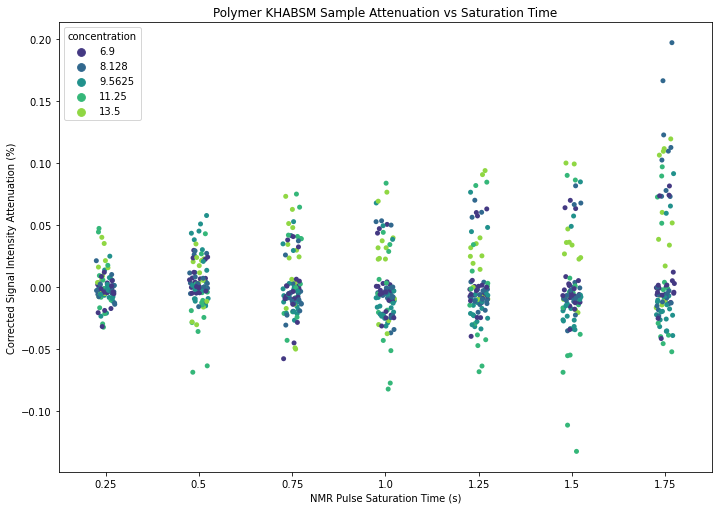

In [166]:
#bonus, visualizations, concentration overlaid with attenuation and saturation time

a4_dims = (11.7, 8.27)
fig1, ax = pyplot.subplots(figsize = a4_dims)
sns.stripplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = corr_attentuation_sample_irrad_df, hue = 'concentration', palette = 'viridis')

plt.title("Polymer KHABSM Sample Attenuation vs Saturation Time")
plt.ylabel("Corrected Signal Intensity Attenuation (%)")
plt.xlabel("NMR Pulse Saturation Time (s)")

Text(0.5, 0, 'NMR Pulse Saturation Time (s)')

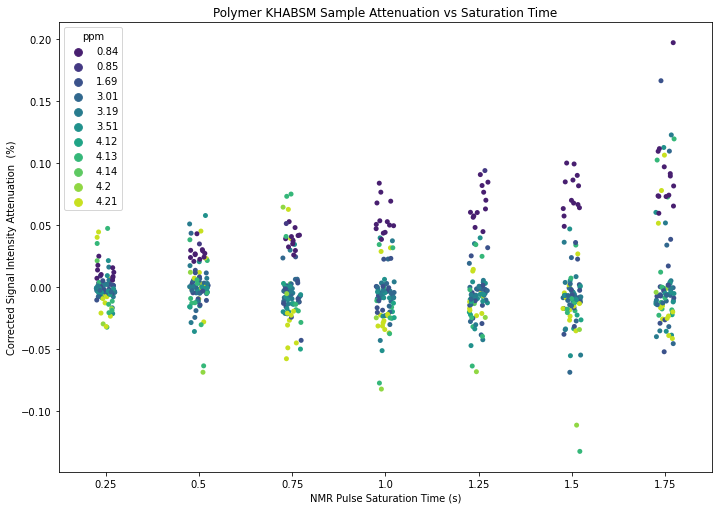

In [167]:
#bonus, visualizations, ppm overlaid with attenuation and saturation time

a4_dims = (11.7, 8.27)
fig2, ax2 = pyplot.subplots(figsize = a4_dims)
sns.stripplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = corr_attentuation_sample_irrad_df, hue = 'ppm', palette = 'viridis')

plt.title("Polymer KHABSM Sample Attenuation vs Saturation Time")
plt.ylabel("Corrected Signal Intensity Attenuation  (%)")
plt.xlabel("NMR Pulse Saturation Time (s)")

In [217]:
#PART 2 -------- Modelling the Data - WIP


